### TensorFlow tutorial and some useful Functions  
  
This notebook is a tutorial for TensorFlow. I will explain the basic usage of TensorFlow and some useful functions.  
### Table of contents

1.- Import the libraries  
2.- Load the Data  
3.- Prepare the Data  
4.- Create a Sequential Model  
5.- Create a Model Using Functional API  
6.- Train the Model  
7.- Predict on Your Own Data  


In [1]:
# Download the dataset used in this example from the following link:
# https://www.xamanekmartinez.com/wp-content/uploads/2024/03/imdb_dataset_Files.zip

# Current dir
#current_dir = os.getcwd()
#print( f"Directorio: { current_dir }" )
# Two levels above directory
#parent_dir = os.path.abspath( os.path.join( current_dir, os.path.pardir, os.path.pardir ) )
#print( f"Directorio padre: { parent_dir }" )
# Path to the data
#directory = parent_dir + "/Datasets/20240215a_data/names/*.txt"

#def findFiles( path ): return glob.glob( path )

#print( findFiles( directory ) )

In [2]:
# To silence the TensorFlow warnings, you can use the following code before importing the TensorFlow library.
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import glob

import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers 
from tensorflow.keras import losses 
import re
import string
import matplotlib.pyplot as plt

print("Imports successful!")

Imports successful!


In [3]:
# Select your favourite number for the random seed and reproducibility
seed = 42

# Sets the global random seed for numpy.
np.random.seed(seed)

# Sets the global random seed for TensorFlow
tf.random.set_seed(seed)

print(f"Random seed set to {seed}")

Random seed set to 42


### Load the data

In [4]:
data_dir = './data_2/aclImdb'

In [5]:
# Here you have two main directories: one for train and one for test data.
# You load files from each to create training and test datasets.

# Create the training set. Use 80% of the data and keep the ramaining 20% for the validation.
raw_training_set = tf.keras.utils.text_dataset_from_directory(
  f'{data_dir}/train',
  labels = 'inferred',
  label_mode = 'int',
  batch_size = 32, 
  validation_split = 0.2,
  subset = 'training',
  seed = seed
)

# Create the validation set. Use 20% of the data that was not used for training.
raw_validation_set = tf.keras.utils.text_dataset_from_directory(
  f'{data_dir}/train', 
  labels = 'inferred',
  label_mode = 'int',
  batch_size = 32,
  validation_split = 0.2, 
  subset = 'validation',
  seed = seed
)

# Create the test set.
raw_test_set = tf.keras.utils.text_dataset_from_directory(
  f'{data_dir}/test',
  labels = 'inferred',
  label_mode = 'int',
  batch_size = 32
)

Found 5000 files belonging to 2 classes.
Using 4000 files for training.
Found 5000 files belonging to 2 classes.
Using 1000 files for validation.
Found 5000 files belonging to 2 classes.


In [6]:
print(f"Label 0 corresponds to {raw_training_set.class_names[0]}")
print(f"Label 1 corresponds to {raw_training_set.class_names[1]}")

Label 0 corresponds to neg
Label 1 corresponds to pos


In [7]:
# Take one batch from the dataset and print out the first three datapoints in the batch
for text_batch, label_batch in raw_training_set.take(1):
  for i in range(3):
    print(f"Review:\n {text_batch.numpy()[i]}")
    print(f"Label: {label_batch.numpy()[i]}\n")

Review:
 b'This is a reunion, a team, and a great episode of Justice. From hesitation to resolution, Clark has made a important leap from a troubled teenager who was afraid of a controlled destiny, to a Superman who, like Green Arrow, sets aside his emotions to his few loved ones, ready to save the whole planet. This is not just a thrilling story about teamwork, loyalty, and friendship; this is also about deciding what\'s more important in life, a lesson for Clark. I do not want the series to end, but I hope the ensuing episodes will strictly stick to what Justice shows without any "rewind" pushes and put a good end here of Smallville---and a wonderful beginning of Superman.<br /><br />In this episode, however, we should have seen more contrast between Lex and the Team. Nine stars should give it enough credit.'
Label: 1

Review:
 b'"Hey Babu Riba" is a film about a young woman, Mariana (nicknamed "Esther" after a famous American movie star), and four young men, Glenn, Sacha, Kicha, and

### Prepare the data

In [8]:
# Set the maximum number of words
max_features = 10000

# Define the custom standardization function 
def custom_standardization( input_data ):
  # Convert all text to lowercase
  lowercase = tf.strings.lower( input_data )
  # Remove HTML tags
  stripped_html = tf.strings.regex_replace( lowercase, '<br />', ' ' )
  # Remove punctuation
  replaced = tf.strings.regex_replace(
    stripped_html, 
    '[%s]' % re.escape( string.punctuation ), 
    ''
  )
  return replaced

# Create a layer that you can use to convert text to vectors
vectorize_layer = layers.TextVectorization(
  standardize = custom_standardization, 
  max_tokens = max_features, 
  output_mode = 'int',
  output_sequence_length = 250
)

In [9]:
# Build the vocabulary
train_text = raw_training_set.map( lambda x, y: x )
vectorize_layer.adapt( train_text )

# Print out the vocabulary size
print( f"Vocabulary size: {len( vectorize_layer.get_vocabulary() )}" )

Vocabulary size: 10000


In [10]:
# Define the final function that you will use to vectorize the text. 
def vectorize_text( text, label ):
  text = tf.expand_dims( text, -1 )
  return vectorize_layer( text ), label

# Get one batch and select the first datapoint
text_batch, label_batch = next( iter( raw_training_set ) )
first_review, first_label = text_batch[0], label_batch[0]

# Show the raw data
print( f"Raw review: {first_review}" )
print( f"\nLabel: {raw_training_set.class_names[first_label]}" )

# Show the vectorized data
print( f"\nVectorized review: {vectorize_text( first_review, first_label )}" )

Raw review: b"Okay, so the plot is on shaky ground. Yeah, all right, so there are some randomly inserted song and/or dance sequences (for example: Adam's concert and Henri's stage act). And Leslie Caron can't really, um, you know... act.<br /><br />But somehow, 'An American In Paris' manages to come through it all as a polished, first-rate musical--largely on the basis of Gene Kelly's incredible dancing talent and choreography, and the truckloads of charm he seems to be importing into each scene with Caron. (He needs to, because she seems to have a... problem with emoting.) <br /><br />The most accomplished and technically awe-inspiring number in this musical is obviously the 16-minute ballet towards the end of the film. It's stunningly filmed, and Kelly and Caron dance beautifully. But my favourite number would have to be Kelly's character singing 'I Got Rhythm' with a bunch of French school-children, then breaking into an array of American dances. It just goes to prove how you don't 

In [11]:
train_ds = raw_training_set.map( vectorize_text )
val_ds = raw_validation_set.map( vectorize_text )
test_ds = raw_test_set.map( vectorize_text )

### Configure the dataset

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch( buffer_size = AUTOTUNE )
test_ds = test_ds.cache().prefetch( buffer_size = AUTOTUNE )

### Create a sequential model

In [13]:
embedding_dim = 16

# Create the model by calling tf.keras.Sequential, where the layers are given in a list.
model_sequential = tf.keras.Sequential(
  [
    layers.Embedding( max_features, embedding_dim ),
    layers.GlobalAveragePooling1D(),
    layers.Dense( 1, activation='sigmoid' )
  ]
)

# Print out the summary of the model
model_sequential.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
model_sequential.compile( 
  loss = losses.BinaryCrossentropy(),
  optimizer = 'adam',
  metrics = ['accuracy']
)

### Create a Model using functional API

In [15]:
# Define the inputs 
inputs = tf.keras.Input( shape = (None,))

# Define the first layer 
embedding = layers.Embedding( max_features, embedding_dim )

# Call the first layer with inputs as the parameter
x = embedding(inputs)

# Define the second layer
pooling = layers.GlobalAveragePooling1D()

# Call the first layer with the output of the previous layer as the parameter 
x = pooling(x)

# Define and acll in the same line. ( Same thing used two lines of code above
# for other layers. You can use any option you prefer. )
outputs = layers.Dense( 1, activation = 'sigmoid' )(x)

# The two-line alternative would be:
#dense = layers.Dense( 1, activation='sigmoid' )
#x = dense(x)

# Create the model
model_functional = tf.keras.Model( inputs = inputs, outputs = outputs )

# Print out the summary of the model 
model_functional.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model_functional.compile( 
  loss = losses.BinaryCrossentropy(),
  optimizer = 'adam',
  metrics = ['accuracy']  
)

### Train the Model

In [17]:
# Select which model you want to use and train, the results should be the same
model = model_functional # model = model_sequential

In [18]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs,
  verbose = 2 
)

Epoch 1/25


I0000 00:00:1710876023.970136  132718 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 - 11s - loss: 0.6907 - accuracy: 0.5520 - val_loss: 0.6874 - val_accuracy: 0.6670 - 11s/epoch - 84ms/step
Epoch 2/25
125/125 - 0s - loss: 0.6800 - accuracy: 0.6927 - val_loss: 0.6739 - val_accuracy: 0.7190 - 310ms/epoch - 2ms/step
Epoch 3/25
125/125 - 0s - loss: 0.6599 - accuracy: 0.7450 - val_loss: 0.6519 - val_accuracy: 0.7410 - 357ms/epoch - 3ms/step
Epoch 4/25
125/125 - 0s - loss: 0.6313 - accuracy: 0.7720 - val_loss: 0.6242 - val_accuracy: 0.7680 - 246ms/epoch - 2ms/step
Epoch 5/25
125/125 - 0s - loss: 0.5977 - accuracy: 0.7897 - val_loss: 0.5947 - val_accuracy: 0.7880 - 380ms/epoch - 3ms/step
Epoch 6/25
125/125 - 0s - loss: 0.5621 - accuracy: 0.8085 - val_loss: 0.5659 - val_accuracy: 0.7980 - 337ms/epoch - 3ms/step
Epoch 7/25
125/125 - 0s - loss: 0.5268 - accuracy: 0.8325 - val_loss: 0.5389 - val_accuracy: 0.8000 - 259ms/epoch - 2ms/step
Epoch 8/25
125/125 - 0s - loss: 0.4928 - accuracy: 0.8508 - val_loss: 0.5141 - val_accuracy: 0.8060 - 238ms/epoch - 2ms/step
Epoch 9/25


### Evaluate the model

In [19]:
loss, accuracy = model.evaluate( test_ds )

print(f"Loss: {loss}")
print("")
print(f"Accuracy: {accuracy}")

157/157 [==============================] - 0s 1ms/step - loss: 0.3644 - accuracy: 0.8458
Loss: 0.3644387423992157

Accuracy: 0.84579998254776


### Plot the metrics

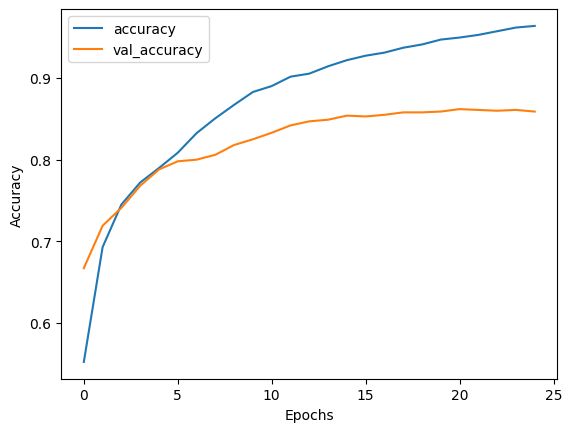

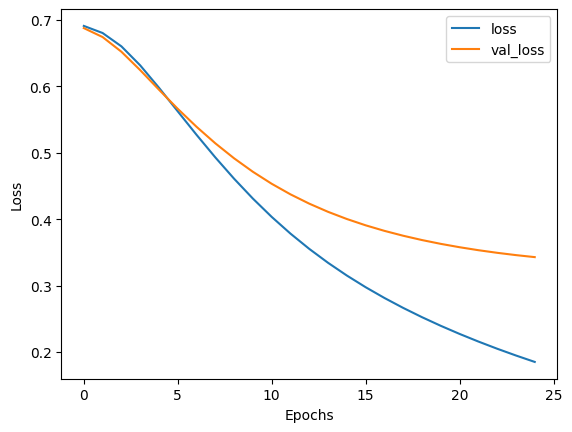

In [20]:
def plot_metrics( history, metric ):
  plt.plot( history.history[metric] )
  plt.plot( history.history[f'val_{metric}'] )
  plt.xlabel( "Epochs" )
  plt.ylabel( metric.title() )
  plt.legend( [metric, f'val_{metric}'] )
  plt.show()

plot_metrics( history, 'accuracy' )
plot_metrics( history, 'loss' )

### Predict your own data

In [21]:
# Make a new sequential model using the vectorization layer and the model you just trained.
export_model = tf.keras.Sequential(
  [
    vectorize_layer, 
    model
  ]
)

# Compile the model
export_model.compile(
  loss = losses.BinaryCrossentropy(
    from_logits = False
  ), 
  optimizer = "adam", 
  metrics = [ 'accuracy' ]
)

In [22]:
examples = [
  'this movie was very, very good', 
  'quite ok', 
  'the movie was not bad', 
  'bad', 
  'negative disappointed bad scary', 
  'this movie was stupid'
]

results = export_model.predict( examples, verbose = False )

for result, example in zip( results, examples ):
  print( f'Result: {result[0]:.3f}, Label: {int(np.round( result[0]))}, Review: {example}')

Result: 0.626, Label: 1, Review: this movie was very, very good
Result: 0.542, Label: 1, Review: quite ok
Result: 0.427, Label: 0, Review: the movie was not bad
Result: 0.473, Label: 0, Review: bad
Result: 0.428, Label: 0, Review: negative disappointed bad scary
Result: 0.456, Label: 0, Review: this movie was stupid
